## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

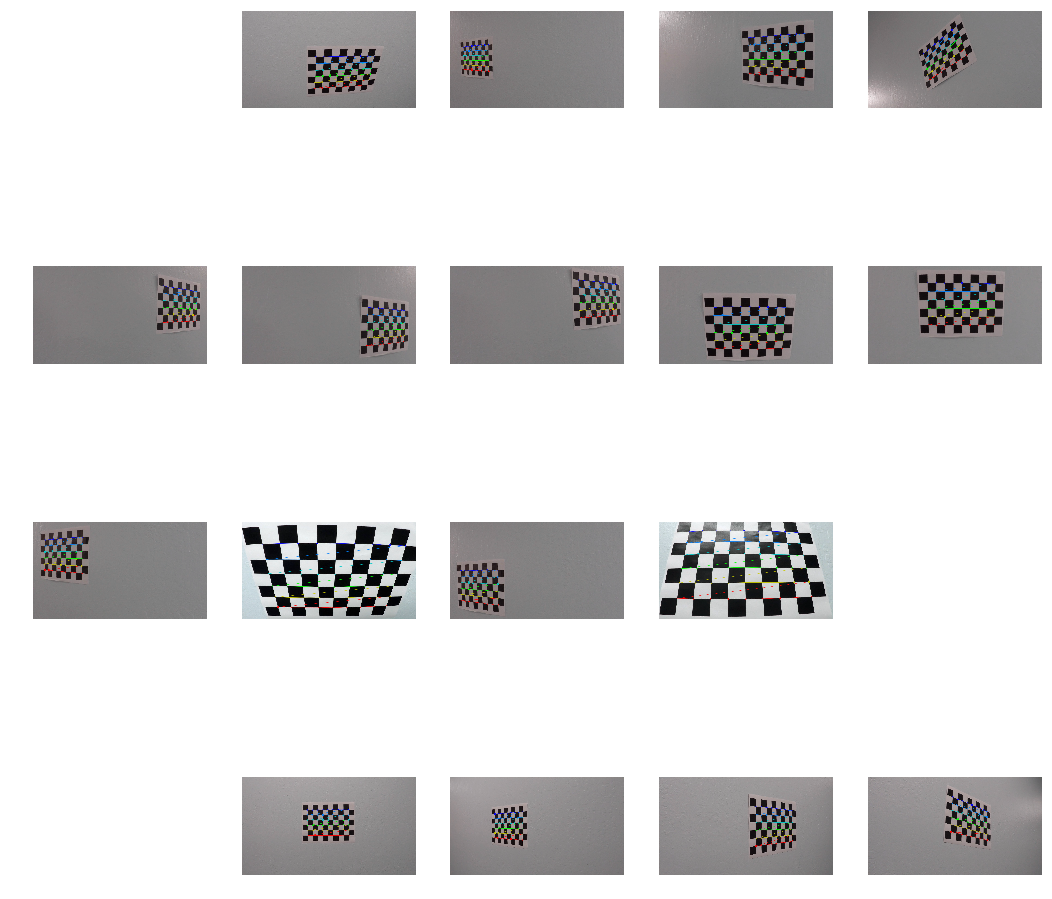

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline



# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\camera_cal\\calibration*.jpg')

n_row = 4
n_col = 5
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(0.2,0.2)

# Step through the list and search for chessboard corners

for i, fname in zip(range(20),images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        ax = fig.add_subplot(n_row,n_col,i+1)
        ax.set_axis_off()
        plt.imshow(img)
    
        

## Camera calibration

True

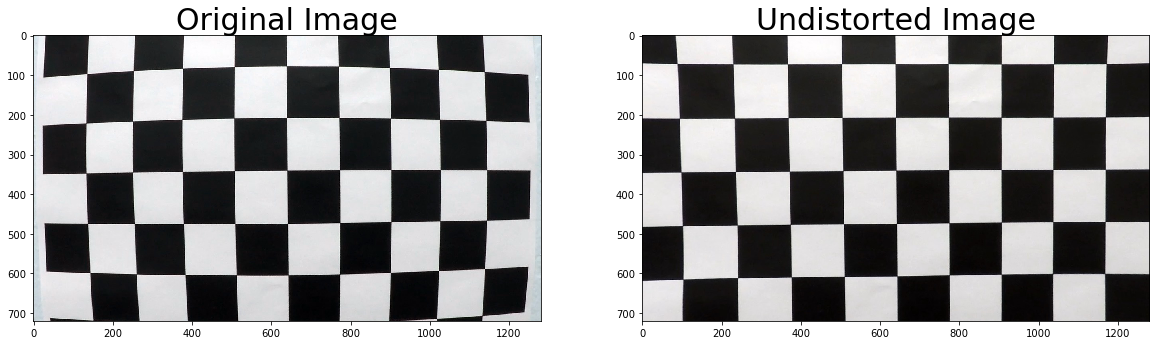

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\camera_cal\\calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\output_images\\undist_img.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\output_images\\calibration_result.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# save the results
cv2.imwrite('C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\output_images\\original_chess_img.jpg',img)
cv2.imwrite('C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\output_images\\undistorted_chess_img.jpg',dst)

## Pipeline for single images

In [3]:
import pickle
import cv2

pickle = pickle.load( open( "C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\output_images\\
calibration_result.p", "rb" ) )
mtx = pickle["mtx"]
dist = pickle["dist"]


In [4]:
# color and gradient thresholding pipeline
def undistortion(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel = 3, mag_thresh = (0,255)):
   
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    gradmag = np.uint8(255*gradmag/np.max(gradmag))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def combined_thresh(img, sobel_thresh=(40,100), sobel_kernel=3, 
                         mag_thresh=(30,100), dir_thresh=(0.7, 1.3)):
    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
     # scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel_x = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) 
    
    # create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    sobelx = np.zeros_like(scaled_sobel_x)
    sobelx[(scaled_sobel_x >= sobel_thresh[0]) & (scaled_sobel_x <= sobel_thresh[1])] = 1
    
    # scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel_y = np.uint8(255*abs_sobely/np.max(abs_sobely)) 
    
    # apply the threshold to sobely
    sobely = np.zeros_like(scaled_sobel_y)
    sobely[(scaled_sobel_y >= sobel_thresh[0]) & (scaled_sobel_y <= sobel_thresh[1])] = 1
    
    
    # calculate the magnitude of the gradient
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    
    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_mag_scaled = np.uint8(255*sobel_mag/np.max(sobel_mag))
    
    # apply the threshold to the magnitude
    mag_sobel = np.zeros_like(sobel_mag_scaled)
    mag_sobel[(sobel_mag_scaled >= mag_thresh[0]) & (sobel_mag_scaled <= mag_thresh[1])] = 1
    
     # Take the absolute value of the gradient direction 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(abs_sobelx, abs_sobely)
    dir_sobel =  np.zeros_like(absgraddir)
    dir_sobel[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    #convert to hls
    hls_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    #black_color = cv2.inRange(hls_image, np.uint8([0,0,0]), np.uint8([75,255,255]))
    #create a copy and combine all of them
    combined_thresh = np.zeros_like(mag_sobel)
    
    combined_thresh[(sobelx == 1) | (mag_sobel == 1)] = 1

    
    return combined_thresh


def color_thresh_1(img, color_thresh_s = (170,255), color_thresh_l = (100,170)):

    # convert to HLS color space and separate the S channel and l channel
    hls_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    
    # convert to the HSV color space    
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # define white and yellow masks
 
    white_color = cv2.inRange(hls_image, np.uint8([10,200,0]), np.uint8([255,255,255]))
    yellow_color = cv2.inRange(hsv_image, np.uint8([15,60,130]), np.uint8([150,255,255]))
    
    # combine yellow and white masks
    yellow_white_mask = cv2.bitwise_or(white_color, yellow_color)
    
    
    ## threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresh_s[0]) & (s_channel <= color_thresh_s[1])] = 1

    ## threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= color_thresh_l[0]) & (l_channel <= color_thresh_l[1])] = 1

    ## combined binaries
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(s_binary == 1) | (yellow_white_mask > 0)] = 1

    return combined_binary


def combine_color_gradient(img, sobel_kernel = 3, sobel_thresh=(40,100), mag_thresh=(30,100), dir_thresh=(0.7, 1.3),
                           color_thresh_s = (170,255), color_thresh_l = (110,170)):
    # denoise image
    #img = cv2.fastNlMeansDenoisingColored(img,7,13,21,5)
   
    combined_threshold = combined_thresh(img, sobel_thresh=(30,100), sobel_kernel=3, mag_thresh=(40,100), dir_thresh=(0.7, 1.3))
    color =  color_thresh_1(img, color_thresh_s = (170,255),  color_thresh_l = (100,170))
    
    # combine color threshold and gradient
    combined_color_gradient = np.zeros_like(combined_threshold)
    combined_color_gradient[(color == 1) | (combined_threshold == 1)] = 1
    return combined_color_gradient




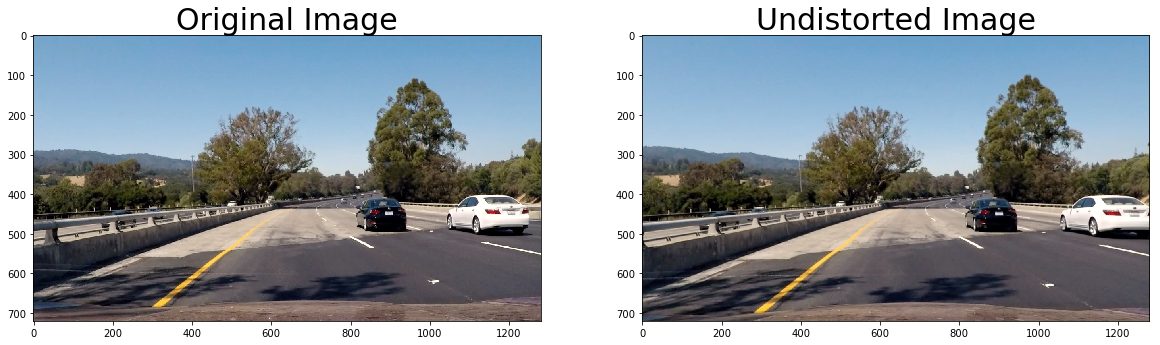

In [5]:
#visualize undistortion

img = cv2.imread("C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\test_images\\test4.jpg")
undistort = undistortion(img, mtx, dist)



# convert from BGR to RGB for display
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB)




f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

#save the undistorted image
#cv2.imwrite('C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\output_images\\undistorted_test1.jpg',undistort)

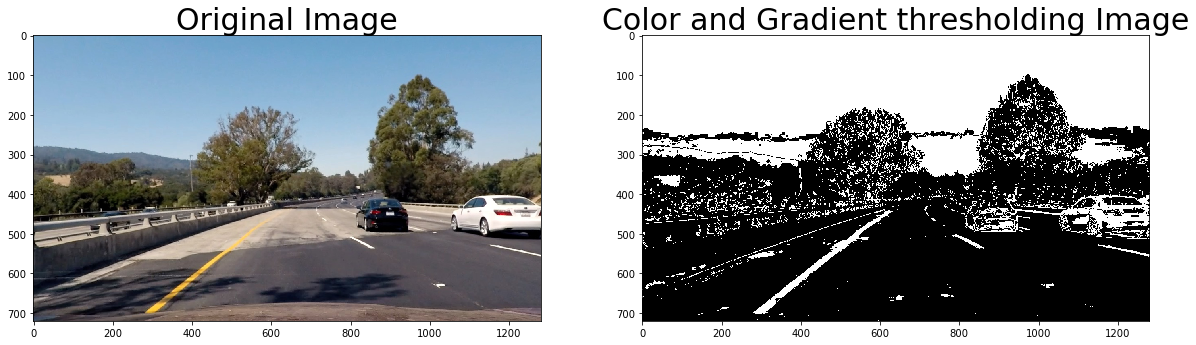

In [6]:
#visualize the color and gradient thresholding

#img = cv2.imread("C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\test_images\\test3.jpg")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary_img = combine_color_gradient(undistort)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_img, cmap = 'gray')
ax2.set_title('Color and Gradient thresholding Image', fontsize=30)




In [7]:
# perspective transform pipeline
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    #four source coordinates
    
    src = np.float32([[580,450],[300,700],[760,450],[1150,700]])
    #four destination coordinates
    dst = np.float32([[300,0], [200,700],[1000,0], [1050,700]])
    #compute the perspective transform matrix, M
    M = cv2.getPerspectiveTransform(src,dst)
    #warp an image using the perspective transform M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M





True

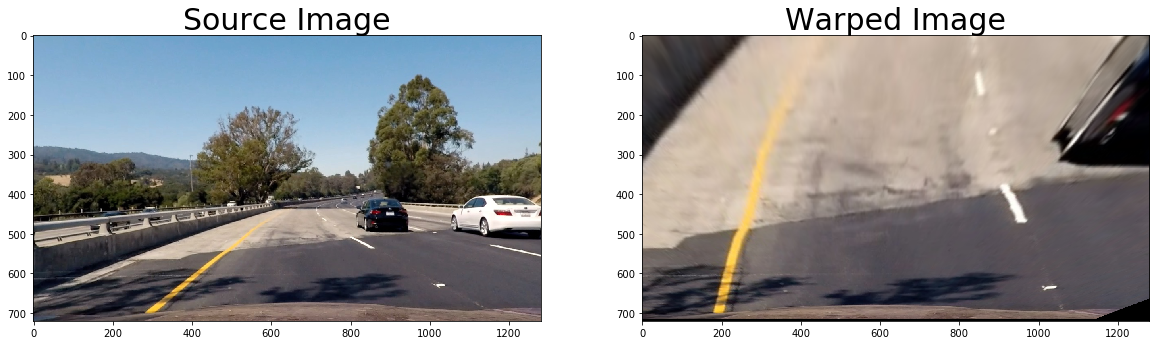

In [8]:
warped_img, M = warp(undist)

#visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Source Image', fontsize=30)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize=30)  

#save the warped image
warped = cv2.cvtColor(warped_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\output_images\\warped_test5.jpg',warped)

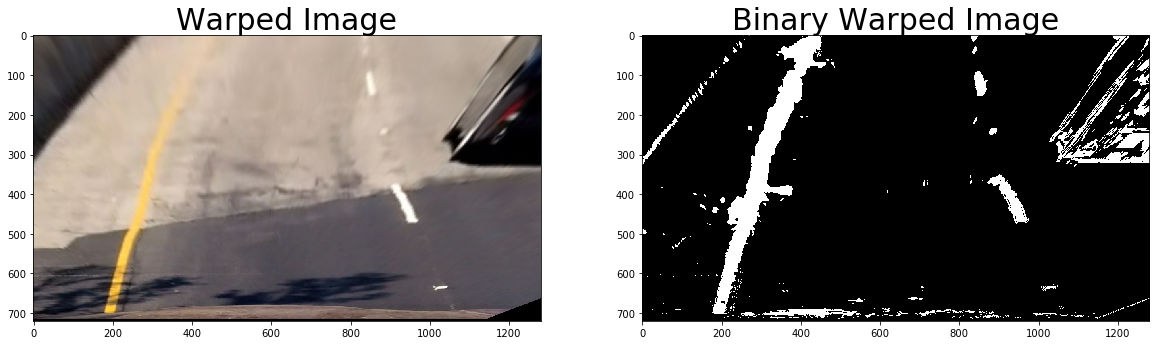

In [9]:


binary_warped_img = combine_color_gradient(warped_img)

#visualize binary image 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped_img)
ax1.set_title('Warped Image', fontsize=30)
ax2.imshow(binary_warped_img, cmap = 'gray')
ax2.set_title('Binary Warped Image', fontsize=30)  



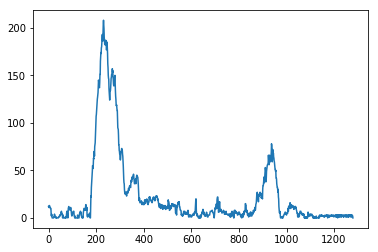

In [10]:
import numpy as np
histo = np.sum(binary_warped_img[binary_warped_img.shape[0]//2:,:],axis = 0)
plt.plot(histo)

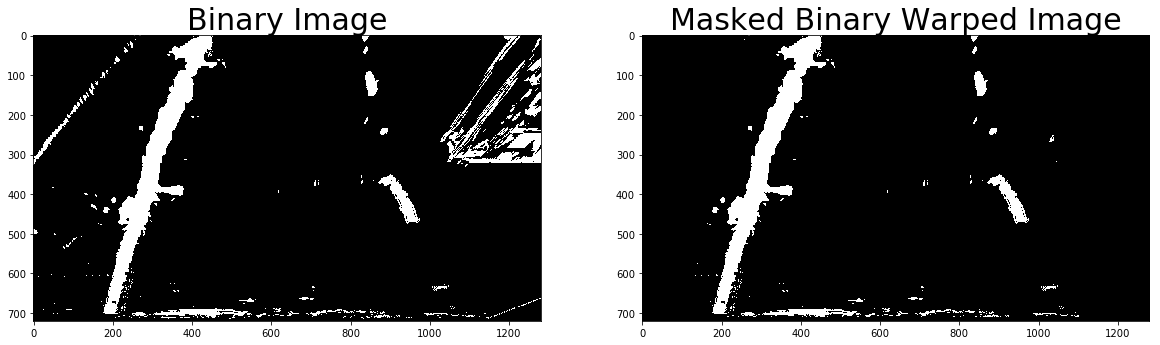

In [11]:

def region_of_interest(img, vertices):
 
   
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
 
#vertices = np.array([[(110, 710),(260, 0), (1150, 0), (1200,710)]], dtype=np.int32)
vertices = np.array([[(110, 710),(260, 0), (1000, 0), (1100,710)]], dtype=np.int32)
masked_binary_img = region_of_interest(binary_warped_img, vertices)

#visualize the region of interest
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary_warped_img, cmap = 'gray')
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(masked_binary_img, cmap = 'gray')
ax2.set_title('Masked Binary Warped Image', fontsize=30)



In [35]:
def find_lane_lines(binary_warped_img):
    # take a histogram of the bottom half
    histogram = np.sum(binary_warped_img[binary_warped_img.shape[0]//2:,:], axis=0)
    # create an output image to visualize the result
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))* 255
    # find the peak of the left and right halves of the histogram which will be
    # the starting point for the left and right lines
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #choose the number of sliding windows
    nwindows = 9
    #set height of windows
    window_height = np.int(binary_warped_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels
    nonzero = binary_warped_img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    # current positions
    leftx_current = leftx_base
    rightx_current = rightx_base
    # set the width of the window
    margin = 85
    # set minimum number of pixels found to recenter window
    minpix = 50
    # create empty lists to store left and right lines
    left_lane_inds = []
    right_lane_inds = []
    # create empty lists to store rectangle points
    rectangle_points = []
    # step through the window one by one
    for window in range(nwindows):
        # Identify window boundaries (x and y coordinates)
        win_y_low = binary_warped_img.shape[0]-(window+1)*window_height
        win_y_high = binary_warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
       # Draw the rectangle window
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        rectangle_points.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
      # find nonzero pixels (x and y coordinates) within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
      # append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
     # if the number of pixels > minpix, then recenter next window use their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

     # concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # extract left and right line positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #generate output image
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
     # find the maximum y value
    y_eval = np.max(ploty)
    
    
    # define conversions in x and y from pixels space to meters 
    ym_per_pix = 40/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/850 # meters per pixel in x dimension
    
     # fit new polynomials
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
     
    # calculate distance from center
    center = binary_warped_img.shape[1]//2
    lane_center = (min(left_fitx)+max(right_fitx))//2
    distance = np.abs(center - lane_center)*xm_per_pix
   
    return out_img, left_fitx, right_fitx, left_fit, right_fit, ploty, rectangle_points, left_curverad, right_curverad, distance

  
        

(720, 0)

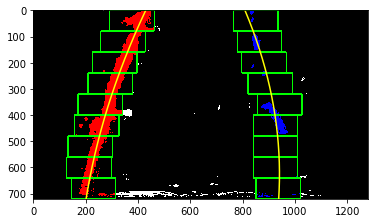

In [36]:
out_img, left_fitx, right_fitx, left_fit_1, right_fit_1, ploty, rectangle_points,left_curverad, right_curverad, distance = find_lane_lines(masked_binary_img)



for rectangle in rectangle_points:
    cv2.rectangle(out_img,(rectangle[2],rectangle[0]),(rectangle[3],rectangle[1]),(0,255,0), 3) 
    cv2.rectangle(out_img,(rectangle[4],rectangle[0]),(rectangle[5],rectangle[1]),(0,255,0), 3) 

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)






In [29]:
def find_new_lines_positions(binary_warped_img, left_fit_previous, right_fit_previous):
    
    
    
    # Identify the x and y positions of all nonzero pixels
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 85
    
    left_lane_inds = ((nonzerox > (left_fit_previous[0]*(nonzeroy**2) + left_fit_previous[1]*nonzeroy + 
    left_fit_previous[2] - margin)) & (nonzerox < (left_fit_previous[0]*(nonzeroy**2) + 
    left_fit_previous[1]*nonzeroy + left_fit_previous[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_previous[0]*(nonzeroy**2) + right_fit_previous[1]*nonzeroy + 
    right_fit_previous[2] - margin)) & (nonzerox < (right_fit_previous[0]*(nonzeroy**2) + 
    right_fit_previous[1]*nonzeroy + right_fit_previous[2] + margin)))  

    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # find the maximum y value
    y_eval = np.max(ploty)
    
    
    # define conversions in x and y from pixels space to meters 
    ym_per_pix = 40/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/850 # meters per pixel in x dimension
    
     # fit new polynomials
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
     
    # calculate distance from center
    center = binary_warped_img.shape[1]//2
    lane_center = (min(left_fitx)+max(right_fitx))//2
    distance = np.abs(center - lane_center)*xm_per_pix
    
    return left_fitx, right_fitx, ploty, left_curverad, right_curverad, distance

    

C:\Users\Sally\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 74719 but corresponding boolean dimension is 50975
C:\Users\Sally\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 74719 but corresponding boolean dimension is 50975


(720, 0)

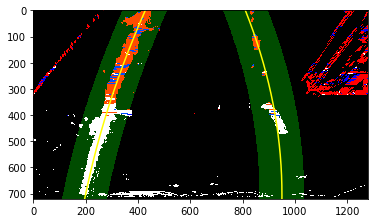

In [34]:
# visualize the result

left_fitx, right_fitx, ploty, left_curverad, right_curverad, distance = find_new_lines_positions(
    masked_binary_img, left_fit_1, right_fit_1)



# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
window_img = np.zeros_like(out_img)


# Identify the x and y positions of all nonzero pixels
nonzero = binary_warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 85

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds_2], nonzerox[left_lane_inds_2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_2], nonzerox[right_lane_inds_2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



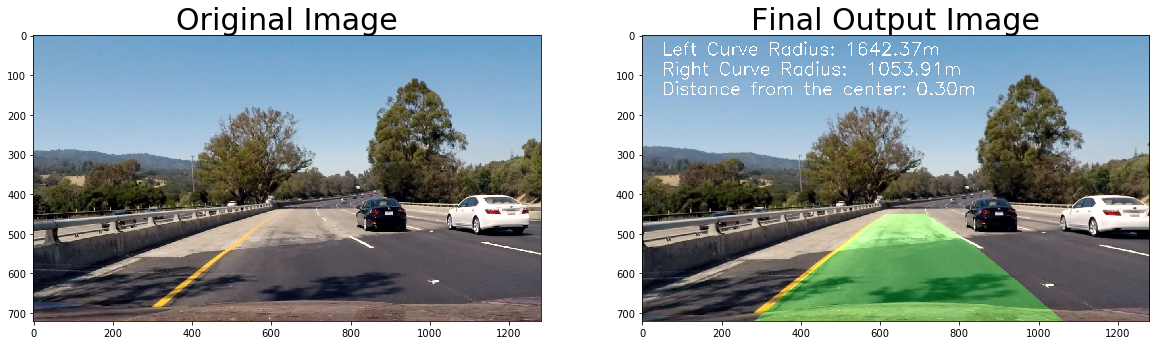

In [37]:
def draw_lane_lines (img, binary_warped_img, M, left_fitx, right_fitx):
     # find the range for y values
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0] )
    # create an image to draw lines
    warp_zero = np.zeros_like(binary_warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #fit lines
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
   # right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # recast the x and y points into usable format
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # draw the lane onto warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # find the inverse perspective matrix
    M_inverse = np.linalg.inv(M)
    # warp the blank back to original image space using inverse perspective matrix
    newwarp = cv2.warpPerspective(color_warp, M_inverse, (img.shape[1], img.shape[0])) 
    # combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3,0)
    return result
result = draw_lane_lines(undistort, binary_warped_img, M, left_fitx, right_fitx)

#left_curve, right_curve, distance = measure_curvature(masked_binary_img, left_lane_inds, right_lane_inds)
# write the curvature info on the image
def info(final_img, left_curve, right_curve, distance):

    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Left Curve Radius: {:.2f}m".format(left_curve)
    cv2.putText(final_img, text, (50,50), font, 1.5, (255,255,255), 2)
    text = "Right Curve Radius:  {:.2f}m".format(right_curve)
    cv2.putText(final_img, text, (50,100), font, 1.5, (255,255,255), 2)
    text = "Distance from the center: {:.2f}m".format(distance)
    cv2.putText(final_img, text, (50,150), font, 1.5, (255,255,255), 2)

    return final_img



#visualize final results
final_result = info(result, left_curverad, right_curverad, distance)


# convert to BGR
result = cv2.cvtColor(final_result, cv2.COLOR_RGB2BGR)

#visualize the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(result)
ax2.set_title('Final Output Image', fontsize=30)

# save the final result
#cv2.imwrite('C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\output_images\\final_result.jpg',result)

In [49]:
from collections import deque

## define a lane detector class

class Line():
    def __init__(self, frames = 20):
        # the line detected
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen = frames)
        # averaged x values of the fitted line 
        self.bestx = None
        # averaged polynomial coefficients
        self.best_fit = None
        # polynomial coefficients for the most recent fit 
        self.current_fit = None
        # radius of curvature
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line  
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype = 'float')
        # detected pixels
        self.indices = deque(maxlen = frames)
    def check_lines(self, current_fit, previous_fit):
        diff = np.sum((current_fit-previous_fit)**2)/np.sum(previous_fit**2)
        sqrt_error = np.sqrt(diff)
        if diff > 0.05:
            self.detected = False
            
            
        else:
            self.detected = True
            self.recent_xfitted.append(current_fit)
            self.current_fit = current_fit
            
            self.best_fit = np.average(self.recent_xfitted, axis = 0)
            #self.indices.append(indices)
        
        

In [50]:
def process_image(img):
    vertices = np.array([[(110, 710),(260, 0), (1000, 0), (1100,710)]], dtype=np.int32)
   
  
    undistort = undistortion(img, mtx, dist)
    binary_img = combine_color_gradient(undistort)
    binary_warped_img, M =  warp(binary_img)
   
    masked_binary = region_of_interest(binary_warped_img, vertices)
    
    global left_lane_indices
    global right_lane_indices
    global l_fit
    global r_fit
 
    try:
        
        out_img,l_fitx, r_fitx,l_fit, r_fit, ploty, rectangle_points, left_curverad, right_curverad, distance  =   find_lane_lines(masked_binary)
        
    except TypeError as e:
        
            l_fitx = None
            r_fitx = None 
            
                
    if l_fitx is not None:
        if left_lane.current_fit is None:
            left_lane.current_fit = l_fitx
            left_lane.detected = True
            left_lane.recent_xfitted.append(l_fitx)
            left_lane.best_fit = l_fitx
            #left_lane.indices.append(left_lane_indices)
        else:
            left_lane.check_lines(l_fitx, left_lane.current_fit)
           
    else:
        left_lane.detected = False
        left_lane.best_fit = np.average(left_lane.recent_xfitted, axis = 0)
    
    if r_fitx is not None:
        if right_lane.current_fit is None:
            right_lane.current_fit = r_fitx
            right_lane.detected = True
            right_lane.recent_xfitted.append(r_fitx)
            right_lane.best_fit = r_fitx
            #right_lane.indices.append(right_lane_indices)
        else: 
            right_lane.check_lines(r_fitx, right_lane.current_fit)
           
    else:
        right_lane.detected = False
        right_lane.best_fit = np.average(right_lane.recent_xfitted, axis = 0)
        
    if  (left_lane.best_fit is not None) and (right_lane.best_fit is not None):
        final_img1 = draw_lane_lines(undistort, binary_warped_img, M, left_lane.best_fit, right_lane.best_fit)
        
        img_out = info(final_img1, left_curverad, right_curverad, distance)
  
        
    else:
        img_out = undistort
    return img_out

  
    
   

In [51]:
# create two line objects
left_lane = Line()
right_lane = Line()



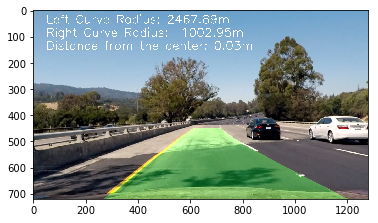

In [52]:
img = cv2.imread("C:\\Users\\Sally\\Anaconda3\\CarND-Advanced-Lane-Lines\\test_images\\test4.jpg")

result = process_image(img)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.imshow(result)

In [53]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [54]:


video_output = "output_videos/final_project_video.mp4"
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/final_project_video.mp4
[MoviePy] Writing video output_videos/final_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:55<00:00,  3.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/final_project_video.mp4 

Wall time: 6min 59s
